# Blablattractivity - Local and tests -

## Data collection

We start with basic imports to use blablacar web api.

In [1]:
#%pip install pandas

In [2]:
#%pip install fsspec

In [3]:
#%pip install google-cloud-storage

In [4]:
#%pip install matplotlib

In [5]:
#%pip install seaborn

In [6]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.dates as mdates
import seaborn as sns
from google.cloud import storage
import datetime 
from math import ceil, floor

Dès qu'on reçoit l'API on part là-dessus : https://dev.blablacar.com/hc/en-us/articles/360012064820--Search-V3-API-Documentation

In [7]:
api_token = open("./api.txt","r").read()
api_url = "https://public-api.blablacar.com"

We have the basic parameters of our API call :

In [8]:
from_coordinate = "48.117266%2C-1.677793" # string : latitude, longitude - RENNES
to_coordinate = "48.390394%2C-4.486076" # string : latitude, longitude - BREST
from_country = "FR" # string : ISO_3166_1
to_country = "FR" # string : ISO_3166_1
locale = "fr-FR" # string : locale in which the result will be displayed https://dev.blablacar.com/hc/en-us/articles/360008930020
currency = "EUR" # string : ISO_4217 currency
number_of_trips_we_want_returned = "100" # int : from 1 to 100, default is 10 
requested_seats = "1" # int : minimum number of seats requested, default value is 1
radius_in_meters = "6000" # int : radius of the circle around the coordinates in which trips will be searched from (in meters)

Then the date of the trip will be different everytime we run the code (it has to be next friday everytime), so we compute it here :

In [9]:
today = datetime.date.today()
friday = today + datetime.timedelta( (4-today.weekday()) % 7 )
next_friday_datetime = str(friday)+"T00:00:00"
start_date_local = next_friday_datetime
title_date = next_friday_datetime[:10].replace('-','')

In [10]:
response = requests.get(api_url+"/api/v3/trips?key="+api_token+"&from_coordinate="+from_coordinate+"&from_country="
                        +from_country+"&to_coordinate="+to_coordinate+"&to_country="+to_country+"&locale="+locale+"&currency="
                        +currency+"&count="+number_of_trips_we_want_returned+"&start_date_local="+start_date_local
                        +"&radius_in_meters="+radius_in_meters+"&sort=price:asc") 

In [11]:
print(response.status_code) # SHOULD BE 200

200


In [12]:
json_trips = response.json() # it's a dictionnary

In [13]:
new_dict = {'trip_id':[],'price_of_the_trip':[],'date':[]}
for dict_trip in json_trips["trips"]:
    trip_id =  dict_trip["link"].split("id=")[1].split("-")[0]
    price_of_the_trip = dict_trip["price"]["amount"]
    new_dict['trip_id'].append(trip_id)
    new_dict['price_of_the_trip'].append(price_of_the_trip)
    new_dict['date'].append(start_date_local[:10])

In [14]:
new_df = pd.DataFrame.from_dict(new_dict)
new_df.price_of_the_trip = new_df.price_of_the_trip.astype('float')    

In [15]:
#old_df = pd.read_csv("./blablacar_rennes_brest.csv",index_col = "Unnamed: 0") 
#old_df.head()
#df_trips = old_df.append(new_df, ignore_index=True, sort=False)
#df_trips.head()
#df_trips.to_csv("./blablacar_rennes_brest.csv")

## Visualization

In [16]:
df_trips = pd.read_csv("./blablacar_rennes_brest.csv",index_col = "Unnamed: 0") 

### Plot number of trips per day

In [65]:
df_trips['date_'] = pd.to_datetime(df_trips['date'], format='%Y-%m-%d')

xticks_max = ceil(df_trips.price_of_the_trip.max())
xticks_min = floor(df_trips.price_of_the_trip.min())
xticks_range = xticks_max - xticks_min

<ipython-input-66-3a581128668a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(df_trips.date, fontsize = 15)


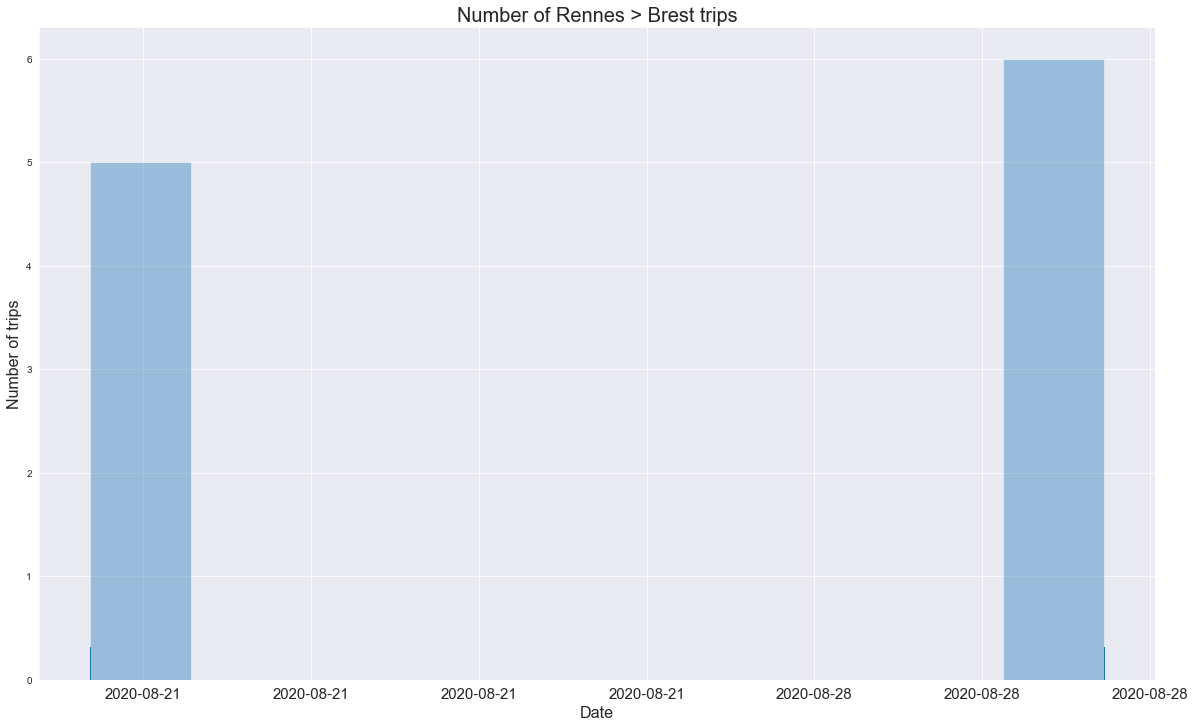

In [66]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,12))

ax_1 = sns.distplot(df_trips.date_, bins=2*xticks_range,kde=False, rug=True)

ax_1.set_title('Number of Rennes > Brest trips', fontsize=20) 
ax_1.set_xticklabels(df_trips.date, fontsize = 15) 

ax_1.set_ylabel('Number of trips', fontsize=16)
ax_1.set_xlabel('Date', fontsize=16)

plt.show()

In [55]:
fig_1 = ax_1.get_figure()
fig_1.savefig('./Plots/number_of_trips_' + title_date + '.png', dpi = 160, format = 'png')

### Plot mean price per day

In [57]:
df_mean = df_trips.groupby(['date'])['price_of_the_trip'].mean().reset_index(name='mean_price')
df_mean['date_'] = pd.to_datetime(df_mean['date'], format='%Y-%m-%d')

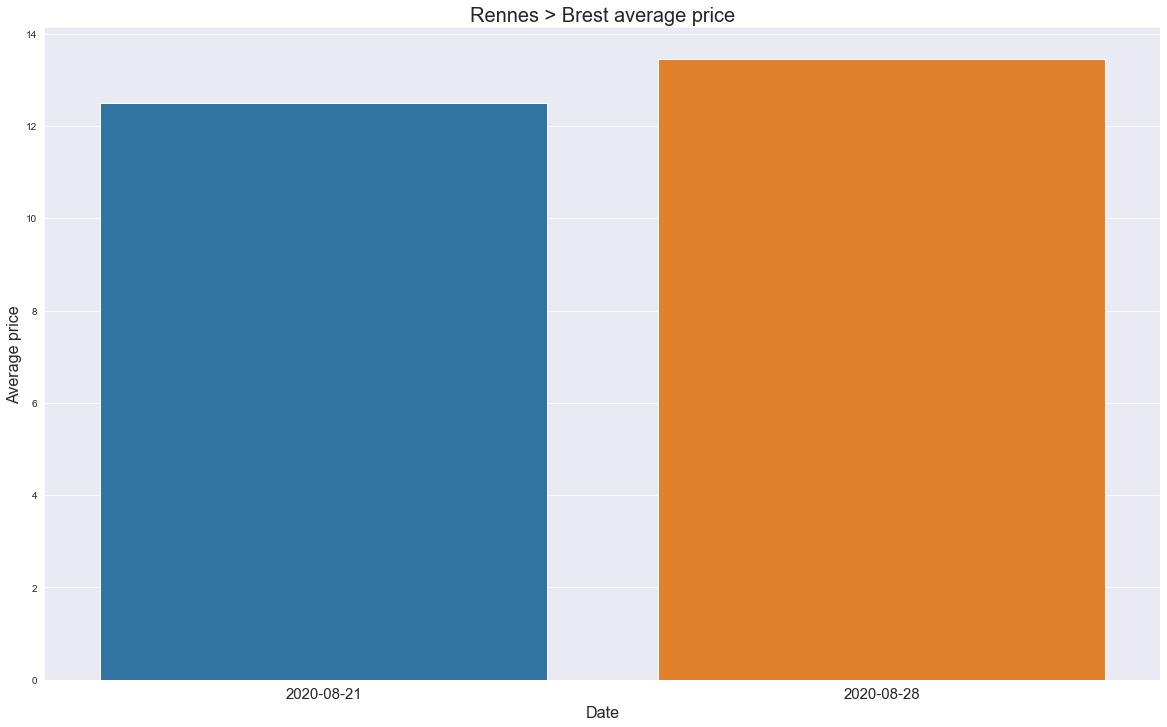

In [58]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,12))

ax_2 = sns.barplot(x="date_", y="mean_price", data = df_mean, order = df_mean["date_"].tolist())

ax_2.set_title('Rennes > Brest average price', fontsize=20) 
ax_2.set_xticklabels(df_mean.date, fontsize = 15) 

ax_2.set_ylabel('Average price', fontsize=16)
ax_2.set_xlabel('Date', fontsize=16)

plt.show()

In [59]:
fig_2 = ax_2.get_figure()
fig_2.savefig('./Plots/average_trip_price_' + title_date + '.png', dpi = 160, format = 'png')

### Plot median price per day

In [60]:
df_median = df_trips.groupby(['date'])['price_of_the_trip'].median().reset_index(name='median_price')
df_median['date_'] = pd.to_datetime(df_median['date'], format='%Y-%m-%d')

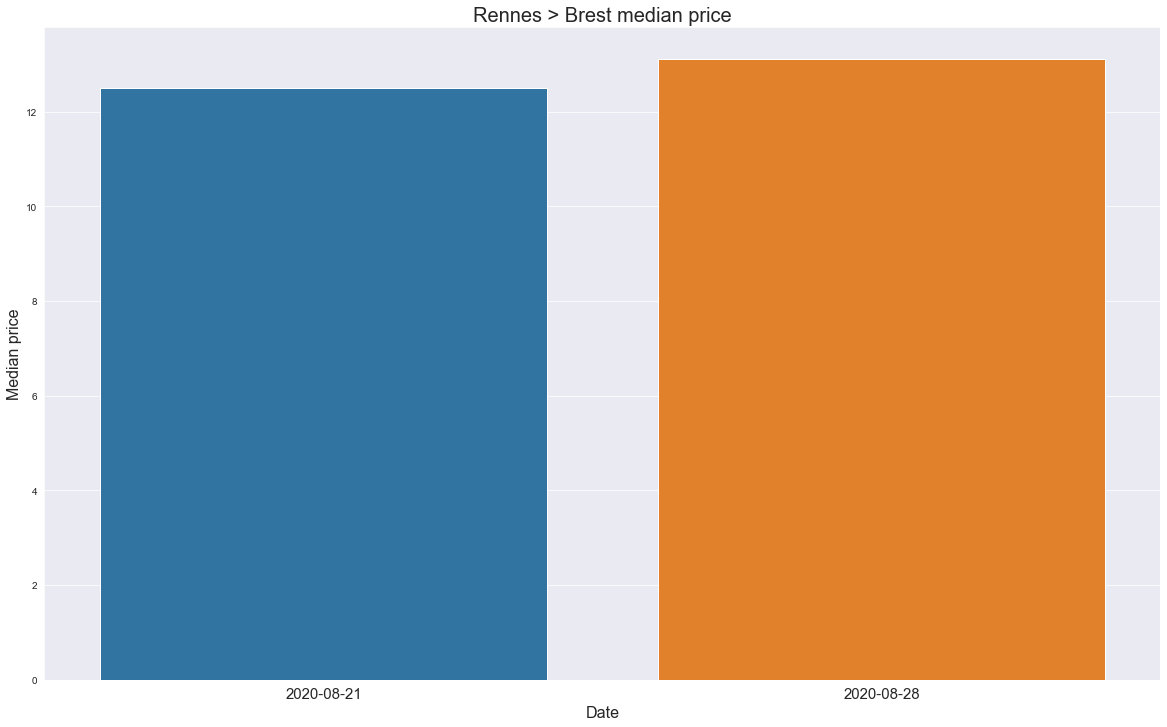

In [67]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,12))

ax_3 = sns.barplot(x="date_", y="median_price", data = df_median, order = df_median["date_"].tolist())

ax_3.set_title('Rennes > Brest median price', fontsize=20) 
ax_3.set_xticklabels(df_median.date, fontsize = 15) 

ax_3.set_ylabel('Median price', fontsize=16)
ax_3.set_xlabel('Date', fontsize=16)

plt.show()

In [62]:
fig_3 = ax_3.get_figure()
fig_3.savefig('./Plots/median_trip_price_' + title_date + '.png', dpi = 160, format = 'png')

### Frequency plot

In [23]:
df_price_freq = df_trips.groupby(df_trips['price_of_the_trip']).size().reset_index(name='price_count')

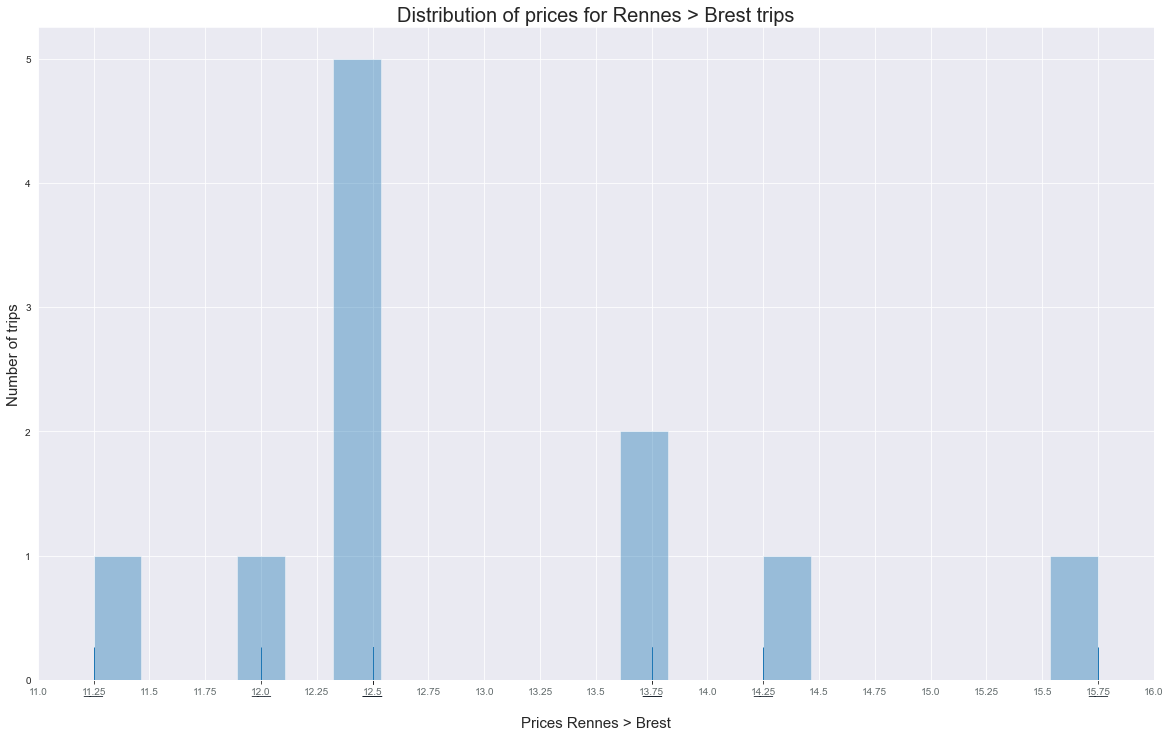

In [70]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,12))

ax_4 = sns.distplot(df_trips.price_of_the_trip, bins=4*xticks_range+1, kde=False, rug=True)

xticks_major = df_trips.price_of_the_trip
xticks_minor = np.linspace(xticks_min, xticks_max, 4*xticks_range+1)
xticks_minor = np.around(xticks_minor, 2)

ax_4.set_xticks(xticks_minor)  
ax_4.set_xticklabels(xticks_minor, color='#616A6B')
ax_4.set_title('Distribution of prices for Rennes > Brest trips', fontsize=20) 
ax_4.set_xlabel('Prices Rennes > Brest', fontsize=15, labelpad = 20 )
ax_4.set_ylabel('Number of trips', fontsize=15)

secax_4 = ax_4.secondary_xaxis('bottom')
secax_4.set_xticks(xticks_major) 
xticks_major_labels = np.full((len(xticks_major),), '___')
secax_4.set_xticklabels(xticks_major_labels, fontsize=12, color='#17202A')

plt.show()

In [71]:
fig_4 = ax_4.get_figure()
fig_4.savefig('./Plots/prices_distribution_' + title_date + '.png', dpi = 160, format = 'png')